# Stanford CME 241 (Winter 2024) - Assignment 6

**Due: Feb 19 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/sanj909/cme241/blob/master/assignments/assignment6.ipynb

*Group members (replace below names with people in your group):* 
- Sanjit Neelam
- Ryan Padnis

## Imports

In [12]:
import itertools
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from typing import Callable, Iterable, Iterator, Mapping, TypeVar

from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.chapter2.simple_inventory_mrp import (
    SimpleInventoryMRPFinite, InventoryState)
from rl.chapter10.prediction_utils import unit_experiences_from_episodes
from rl.distribution import Choose
import rl.iterate as iterate
from rl.iterate import last
from rl.function_approx import learning_rate_schedule, Tabular
import rl.markov_process as mp
from rl.markov_process import TransitionStep, NonTerminal
from rl.monte_carlo import mc_prediction
from rl.returns import returns
import rl.td as td

## Question 1
We consider a special case of the Optimal Market-Making problem we
covered in class (Avellaneda-Stoikov formulation) where the market-maker
has a cash amount of $W \in \mathbb{R}$ at time 0 and an inventory of
shares equal to $I \in \mathbb{Z}$ (note: this could be positive or
negative), but is not going to be market-making until time $T$. The
market maker's *Value Function* at time $t$ (with $0 \leq t \leq T$) is
given by the Expected Utility at time $T$ (conditional on the time $t$
and the OB Mid Price $S_t$ at time $t$):

$$V(t, S_t, W, I) = \mathbb{E}[-e^{-\gamma \cdot (W + I \cdot S_T)} | (t, S_t)]$$

Assume the same process for the OB Mid Price as we had covered in class:

$$dS_t = \sigma \cdot dz_t$$

for some fixed $\sigma \in \mathbb{R}^+$. This means:

$$S_{t_2} \sim \mathcal{N}(S_{t_1}, \sigma^2 \cdot (t_2 - t_1))$$

for all $0 \leq t_1 \leq t_2$.

-   Under this process for $S_t$, evaluate the conditional expectation
    $\mathbb{E}[-e^{-\gamma \cdot (W + I \cdot S_T)} | (t, S_t)]$ so you
    have a simple expression for $V(t, S_t, W, I)$.

-   Using the above expression for $V(t, S_t, W, I)$, calculate the
    Indifference Bid Price $Q^{(b)}(t, S_t, I)$ and the Indifference Ask
    Price $Q^{(a)}(t,S_t,I)$, which have the same definitions as we had
    covered in class, as follows:

    $$V(t,S_t,W - Q^{(b)}(t, S_t, I), I + 1) = V(t,S_t,W, I)$$
    $$V(t,S_t,W + Q^{(a)}(t, S_t, I), I - 1) = V(t,S_t,W, I)$$

- We have
\begin{alignat*}{2}
    &\qquad& S_T &\sim \mathcal{N}(S_t, \sigma^2 (T - t)) \\
    \implies&& X:= -\gamma (W + IS_T) &\sim \mathcal{N}(-\gamma (W + IS_t), \gamma^2 I^2 \sigma^2 (T - t)) \\
    \implies&& \mathbb{E}[-e^{-\gamma \cdot (W + I \cdot S_T)} | (t, S_t)] &= - \mathbb{E} [ e^X ] = - \exp \left( -\gamma (W + IS_t) + \frac{1}{2} \gamma^2 I^2 \sigma^2 (T - t) \right).
\end{alignat*}
- Then
\begin{alignat*}{2}
    &\qquad& V(t,S_t,W - Q^{(b)}(t, S_t, I), I + 1) &= V(t,S_t,W, I) \\
    \iff&& - \exp \left( -\gamma (W - Q^{(b)}(t, S_t, I) + (I + 1) S_t) + \frac{1}{2} \gamma^2 (I + 1)^2 \sigma^2 (T - t) \right) &= - \exp \left( -\gamma (W + I S_t) + \frac{1}{2} \gamma^2 I^2 \sigma^2 (T - t) \right) \\
    \iff&& - W + Q^{(b)}(t, S_t, I) - (I + 1) S_t + \frac{1}{2} \gamma (I + 1)^2 \sigma^2 (T - t) &= - W - I S_t + \frac{1}{2} \gamma I^2 \sigma^2 (T - t) \\
    \iff&& Q^{(b)}(t, S_t, I) - S_t &= \frac{1}{2} \gamma \sigma^2 (T - t) (I^2 - (I + 1)^2) \\
    \implies&& Q^{(b)}(t, S_t, I) &= S_t - \frac{1}{2} \gamma \sigma^2 (T - t) (1 + 2I),
\end{alignat*}
and similarly
\begin{alignat*}{2}
    &\qquad& V(t,S_t,W + Q^{(a)}(t, S_t, I), I - 1) &= V(t,S_t,W, I) \\
    \iff&& - \exp \left( -\gamma (W + Q^{(a)}(t, S_t, I) + (I - 1) S_t) + \frac{1}{2} \gamma^2 (I - 1)^2 \sigma^2 (T - t) \right) &= - \exp \left( -\gamma (W + I S_t) + \frac{1}{2} \gamma^2 I^2 \sigma^2 (T - t) \right) \\
    \iff&& W + Q^{(a)}(t, S_t, I) + (I - 1) S_t - \frac{1}{2} \gamma (I - 1)^2 \sigma^2 (T - t) &= W + I S_t - \frac{1}{2} \gamma I^2 \sigma^2 (T - t) \\
    \iff&& Q^{(a)}(t, S_t, I) - S_t &= \frac{1}{2} \gamma \sigma^2 (T - t) ((I - 1)^2 - I^2) \\
    \implies&& Q^{(a)}(t, S_t, I) &= S_t + \frac{1}{2} \gamma \sigma^2 (T - t) (1 - 2I).
\end{alignat*}

## Question 2
We'd like to test the performance of the Optimal Policy we derived in
class for the Optimal Market-Making problem. In particular, we want to
compare this Optimal Policy against a policy (call it "Naive Policy")
that is always symmetric around the OB Mid Price (rather than around the
Indifference Price) with a constant Bid-Ask Spread equal to the average
Bid-Ask Spread of the Optimal Policy.

We will do the comparison by generating a large number of simulation
traces. Each simulation trace consists of $\frac T {\Delta t}$ time
steps. The time step $\Delta t$ needs to be small enough so that the
probability of multiple orders transacting with the market-maker is
small but needs to be large enough so that there are indeed orders that
transact with the market-maker. In their paper, Avellaneda-Stoikov point
out that $\Delta t = 0.005$ worked well in their simulation experiments.

Here are the details on how to perform a time step in each simulation
trace for the Optimal Policy:

-   At each time $t$, we observe the *State*, and calculate the Optimal
    Action $(P_t^{(b)^*}, P_t^{(a)^*})$.

-   With probability
    $c \cdot e^{-k \cdot \delta_t^{(a)^*}} \cdot \Delta t$, the
    inventory variable is decremented by 1 and the trading PnL is
    increased by $P_t^{(a)^*}$.

-   With probability
    $c \cdot e^{-k \cdot \delta_t^{(b)^*}} \cdot \Delta t$, the
    inventory variable is incremented by 1 and the trading PnL is
    decreased by $P_t^{(b)^*}$.

-   The OB Mid Price is incremented or decremented randomly (each with
    probability 0.5) by $\sigma \cdot \sqrt{\Delta t}$.

-   These updates to the inventory variable, to the trading PnL and to
    the OB Mid Price give us the *State* for the next time
    $t + \Delta t$.

We run a large number (say 10,000) such simulation traces. We calculate
the average Bid-Ask Spread across all time steps across all simulation
traces. Then we set the Bid-Ask Spread for the "naive policy" to be this
average Bid-Ask Spread (constant Bid-Ask Spread). Repeat the same large
number of simulations for the "naive policy".

Track the relevant metrics for each simulation trace on both the
policies - the trading PnL, the Inventory, the OB Mid Price, the Bid
Price, the Ask Price, the number of hits and lifts etc. Plot graphs for
these metrics. You can view the metrics on a single simulation trace or
you can view the average metrics at a fixed time (in particular for
terminal time $T$). Demonstrate empirically that the Optimal Policy does
indeed perform better than the "naive policy".

Avellaneda-Stoikov used the following parameters in their simulation:

$S_0 = 100, T = 1, \Delta t = 0.005, \gamma = 0.1, \sigma = 2, I_0 = 0, k = 1.5, c = 140$.

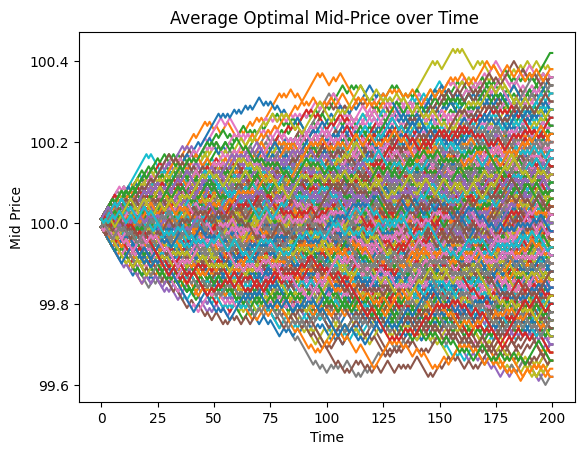

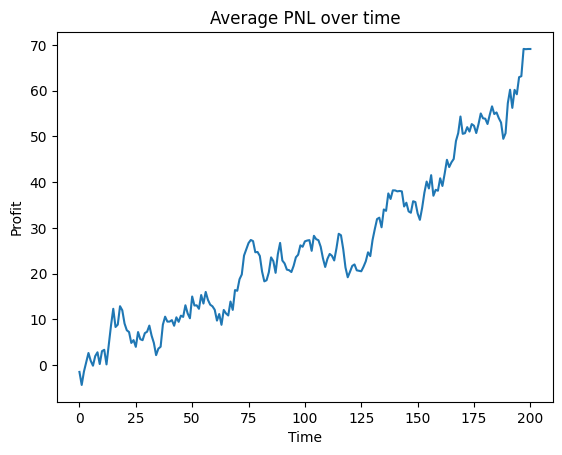

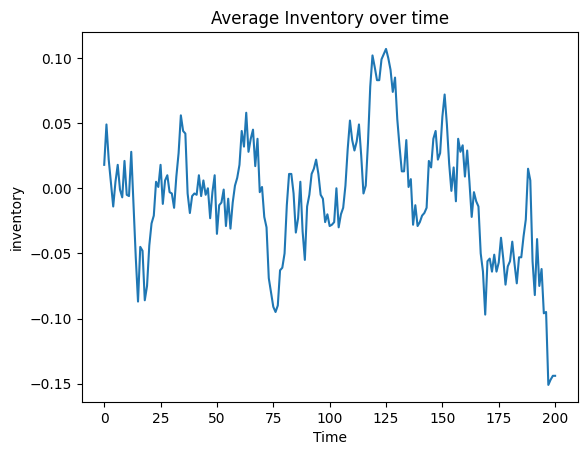

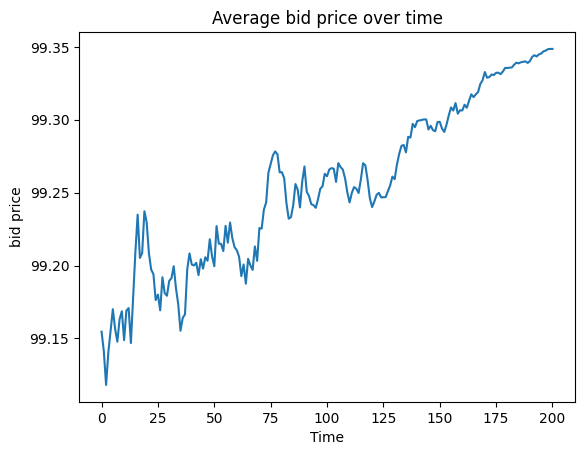

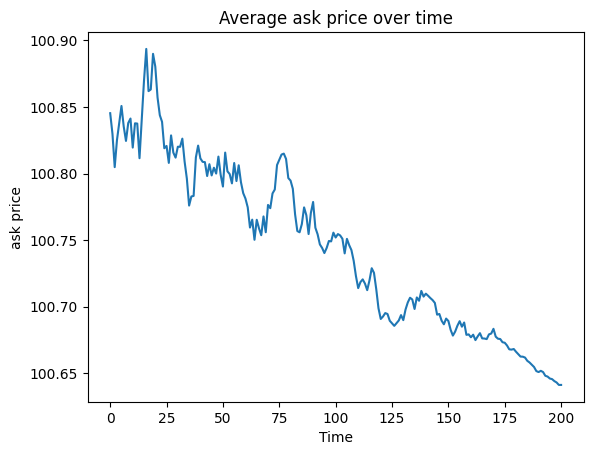

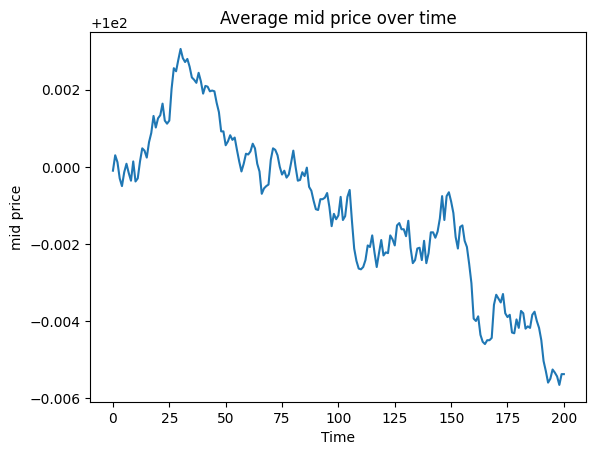

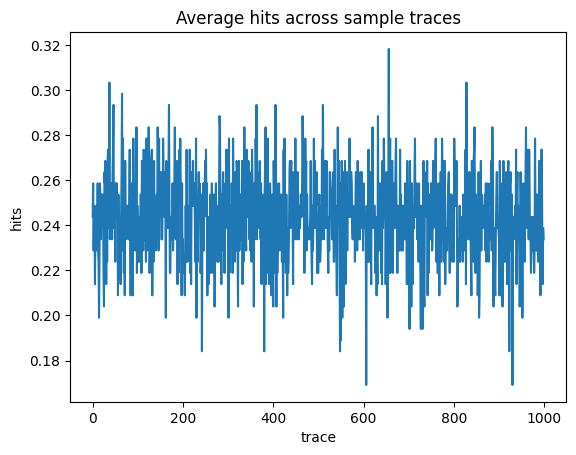

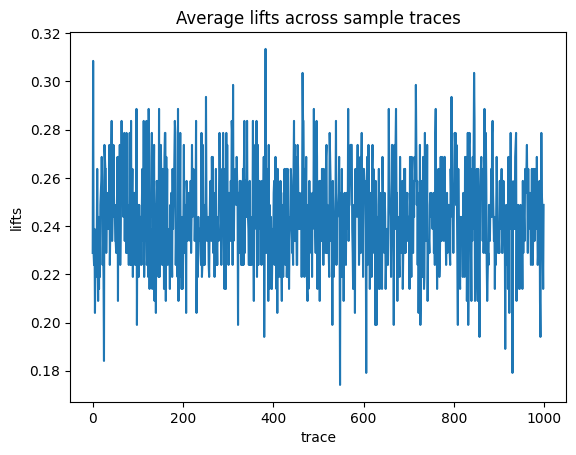

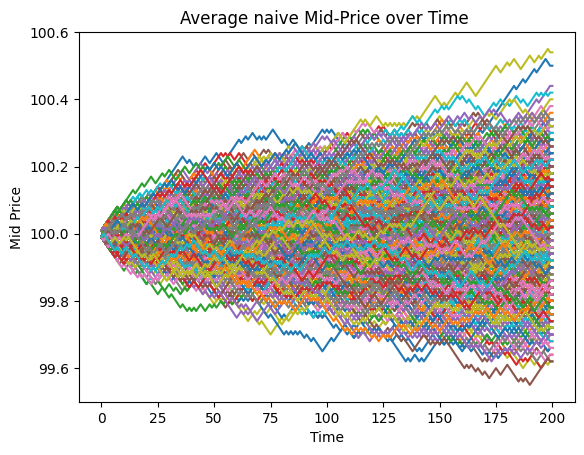

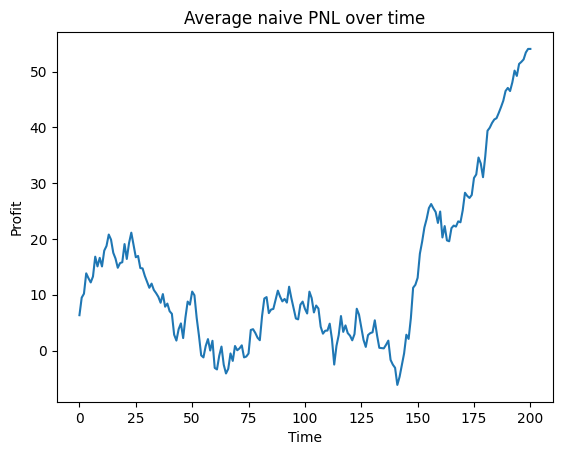

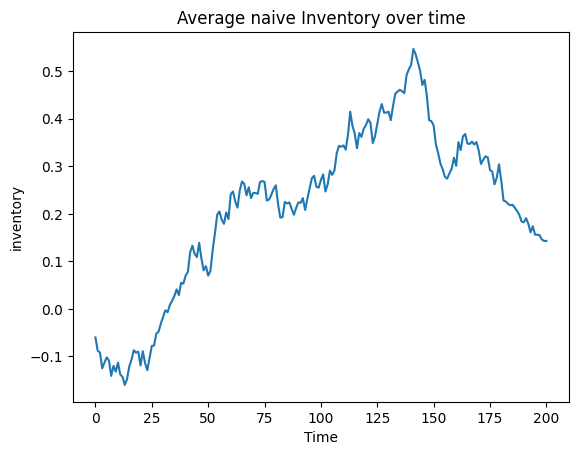

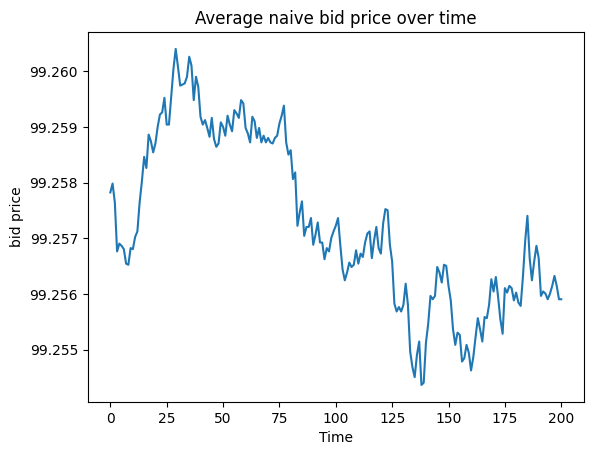

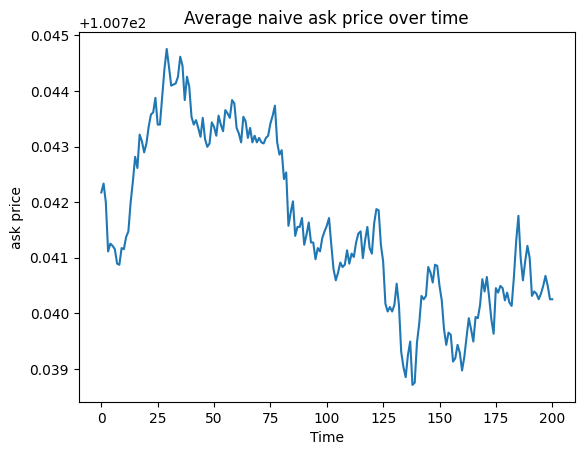

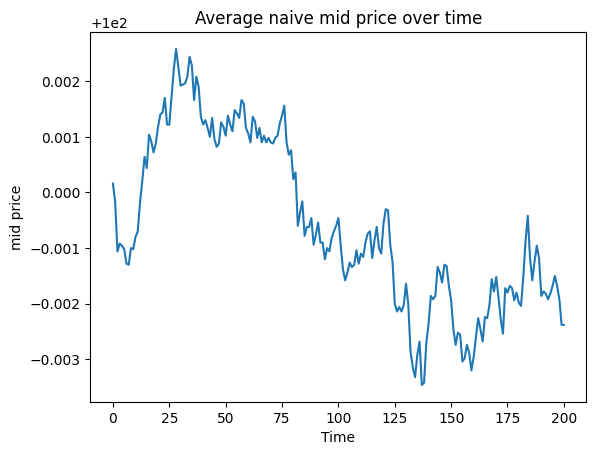

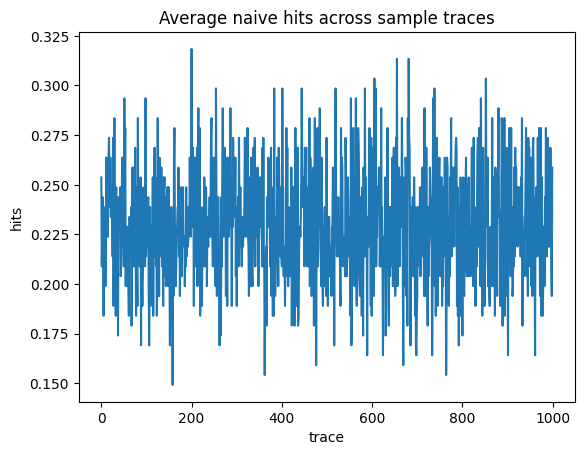

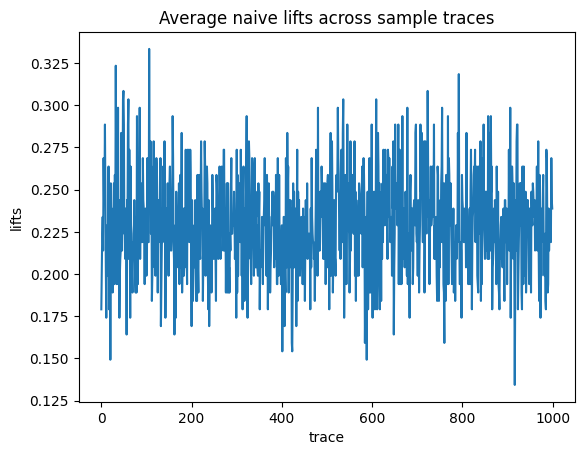

69.09335851623398
54.05322927975111


In [13]:
#avallaneda-stokoiv parameters
num_traces = 1000
k = 1.5
c = 140
T = 1
dt = 0.005
intitial_price = 100
num_time_steps = int(T/dt)
gamma = 0.1
sigma = 2

plt.figure()

mid_prices = np.zeros((num_traces, num_time_steps + 1))#optimal mid prices
pnl = np.zeros((num_traces, num_time_steps + 1))#profit and loss

bid_prices = np.zeros((num_traces, num_time_steps + 1))
ask_prices = np.zeros((num_traces, num_time_steps + 1))

hits = np.zeros((num_traces, num_time_steps + 1)) 
lifts = np.zeros((num_traces, num_time_steps + 1))
spread = np.zeros((num_traces, num_time_steps + 1))#optimal spreads
inventory = np.zeros((num_traces, num_time_steps + 1))

#optimal policy
for trace in range(num_traces): 
    mid_prices[trace, 0] = 100 #intialize state to 100
    for t in range(num_time_steps):
        delta_bid = (2*inventory[trace, t] + 1)*gamma*(sigma**2)*(T - t*dt)*0.5 + (1/gamma)*(np.log(1 + gamma/k))
        delta_ask = (1 - 2*inventory[trace, t])* gamma*(sigma**2)*(T - t*dt)*0.5 + (1/gamma)*(np.log(1 + gamma/k))
        spread[trace, t] = delta_bid + delta_ask
        optimal_mid = mid_prices[trace, t] - inventory[trace,t]*gamma*(sigma**2)*(T - t*dt)
        
        bid_prices[trace, t] = optimal_mid - delta_bid
        ask_prices[trace, t] = optimal_mid + delta_ask
        
        # Sample random numbers for probability calculation
        p_a = c * np.exp(-k * delta_ask)* dt
        p_b = c * np.exp(-k * delta_bid) * dt
        rand_num = np.random.uniform(0, 1)
        # Determine whether to increment or decrement inventory based on probabilities (hit or lift)
        if rand_num < p_a: #lift
            lifts[trace, t] += 1
            inventory[trace, t] -= 1
            pnl[trace, t] += ask_prices[trace, t]
        elif rand_num < p_b + p_a: #hit
            hits[trace, t] += 1
            inventory[trace, t] += 1
            pnl[trace, t] -= bid_prices[trace, t]
        #increment OB mid price randomly
        rand_num = np.random.uniform(0, 1)
        if rand_num < 0.5:
            mid_prices[trace, t] += sigma*dt
        else:
            mid_prices[trace, t] -= sigma*dt
        
        
        #intiialize next state
        bid_prices[trace, t+1] = bid_prices[trace, t]
        ask_prices[trace, t+1] = ask_prices[trace, t]
        inventory[trace, t + 1] = inventory[trace, t]
        pnl[trace, t+1] = pnl[trace, t] 
        mid_prices[trace, t + 1] = mid_prices[trace, t]
    
    plt.plot(mid_prices[trace], label=f'Trace {trace+1}')

plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.title(f'Average Optimal Mid-Price over Time ')

plt.show()


optimal_average_pnl = np.mean(pnl, axis = 0)
optimal_average_inventory = np.mean(inventory, axis = 0)
optimal_average_bid = np.mean(bid_prices, axis = 0)
optimal_average_ask = np.mean(ask_prices, axis = 0)
optimal_average_mid_price = np.mean(mid_prices, axis = 0)
average_hits = np.mean(hits, axis = 1)#across sample traces
average_lifts = np.mean(lifts, axis = 1)

#metrics for optimal market making
plt.figure()
plt.plot(optimal_average_pnl)
plt.xlabel('Time')
plt.ylabel('Profit')
plt.title(f'Average PNL over time')
plt.show()

plt.figure()
plt.plot(optimal_average_inventory)
plt.xlabel('Time')
plt.ylabel('inventory')
plt.title(f'Average Inventory over time')
plt.show()

plt.figure()
plt.plot(optimal_average_bid)
plt.xlabel('Time')
plt.ylabel('bid price')
plt.title(f'Average bid price over time')
plt.show()

plt.figure()
plt.plot(optimal_average_ask)
plt.xlabel('Time')
plt.ylabel('ask price')
plt.title(f'Average ask price over time')
plt.show()

plt.figure()
plt.plot(optimal_average_mid_price)
plt.xlabel('Time')
plt.ylabel('mid price')
plt.title(f'Average mid price over time')
plt.show()

plt.figure()
plt.plot(average_hits)
plt.xlabel('trace')
plt.ylabel('hits')
plt.title(f'Average hits across sample traces')
plt.show()

plt.figure()
plt.plot(average_lifts)
plt.xlabel('trace')
plt.ylabel('lifts')
plt.title(f'Average lifts across sample traces')
plt.show()

global_spread_average = np.mean(spread) #for naive policy









#naive policy
mid_prices = np.zeros((num_traces, num_time_steps + 1))#optimal mid prices
pnl = np.zeros((num_traces, num_time_steps + 1))#profit and loss

bid_prices = np.zeros((num_traces, num_time_steps + 1))
ask_prices = np.zeros((num_traces, num_time_steps + 1))

hits = np.zeros((num_traces, num_time_steps + 1)) 
lifts = np.zeros((num_traces, num_time_steps + 1))
spread = np.zeros((num_traces, num_time_steps + 1))#optimal spreads
inventory = np.zeros((num_traces, num_time_steps + 1))


for trace in range(num_traces): 
    mid_prices[trace, 0] = 100 #intialize state to 100
    for t in range(num_time_steps):
        spread[trace, t] = global_spread_average
        delta_bid = global_spread_average/2
        delta_ask = global_spread_average/2
        
        bid_prices[trace, t] = mid_prices[trace, t] - delta_bid
        ask_prices[trace, t] = mid_prices[trace, t] + delta_ask
        
        # Sample random numbers for probability calculation
        p_a = c * np.exp(-k * delta_ask)* dt
        p_b = c * np.exp(-k * delta_bid) * dt
        rand_num = np.random.uniform(0, 1)
        # Determine whether to increment or decrement inventory based on probabilities (hit or lift)
        if rand_num < p_a: #lift
            lifts[trace, t] += 1
            inventory[trace, t] -= 1
            pnl[trace, t] += ask_prices[trace, t]
        elif rand_num < p_b + p_a: #hit
            hits[trace, t] += 1
            inventory[trace, t] += 1
            pnl[trace, t] -= bid_prices[trace, t]
        #increment OB mid price randomly
        rand_num = np.random.uniform(0, 1)
        if rand_num < 0.5:
            mid_prices[trace, t] += sigma*dt
        else:
            mid_prices[trace, t] -= sigma*dt
        
        
        #intiialize next state
        bid_prices[trace, t+1] = bid_prices[trace, t]
        ask_prices[trace, t+1] = ask_prices[trace, t]
        inventory[trace, t + 1] = inventory[trace, t]
        pnl[trace, t+1] = pnl[trace, t] 
        mid_prices[trace, t + 1] = mid_prices[trace, t]
    
    plt.plot(mid_prices[trace], label=f'Trace {trace+1}')

plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.title(f'Average naive Mid-Price over Time ')

plt.show()


naive_average_pnl = np.mean(pnl, axis = 0)
naive_average_inventory = np.mean(inventory, axis = 0)
naive_average_bid = np.mean(bid_prices, axis = 0)
naive_average_ask = np.mean(ask_prices, axis = 0)
naive_average_mid_price = np.mean(mid_prices, axis = 0)
naive_average_hits = np.mean(hits, axis = 1)#across sample traces
naive_average_lifts = np.mean(lifts, axis = 1)

#metrics for optimal market making
plt.figure()
plt.plot(naive_average_pnl)
plt.xlabel('Time')
plt.ylabel('Profit')
plt.title(f'Average naive PNL over time')
plt.show()

plt.figure()
plt.plot(naive_average_inventory)
plt.xlabel('Time')
plt.ylabel('inventory')
plt.title(f'Average naive Inventory over time')
plt.show()

plt.figure()
plt.plot(naive_average_bid)
plt.xlabel('Time')
plt.ylabel('bid price')
plt.title(f'Average naive bid price over time')
plt.show()

plt.figure()
plt.plot(naive_average_ask)
plt.xlabel('Time')
plt.ylabel('ask price')
plt.title(f'Average naive ask price over time')
plt.show()

plt.figure()
plt.plot(naive_average_mid_price)
plt.xlabel('Time')
plt.ylabel('mid price')
plt.title(f'Average naive mid price over time')
plt.show()

plt.figure()
plt.plot(naive_average_hits)
plt.xlabel('trace')
plt.ylabel('hits')
plt.title(f'Average naive hits across sample traces')
plt.show()

plt.figure()
plt.plot(naive_average_lifts)
plt.xlabel('trace')
plt.ylabel('lifts')
plt.title(f'Average naive lifts across sample traces')
plt.show()



print(optimal_average_pnl[num_time_steps])
print(naive_average_pnl[num_time_steps])
#clearly according the the average at the final time steps across all simulations, the pnl generated from the optimal policy is greater than the naive policy

## Question 3
Although the provided code contains a number of utilties for Monte-Carlo
prediction, you may consider writing re-writing these functions to
improve your understanding.

1.  We have written the function `mc_prediction` in
    [rl/monte_carlo.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/monte_carlo.py)
    as an implementation of Monte-Carlo Prediction with function
    approximation. You have also learnt that since Tabular MC Prediction
    is a special case of MC Prediction with Function Approximation and
    so, writing a separate function for Tabular MC Prediction is not
    necessary. But for a learning experience, it's a great idea to write
    a function for Tabular MC Prediction **from scratch**. Think about
    what the input and output types must be. Be sure to reduce the
    learning rate appropriately as a function of number of updates (or
    as a function of number of episodes).

2.  We have written the function `td_prediction` in
    [rl/td.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/td.py)
    as an implementation of Temporal-Difference Prediction with function
    approximation. You have also learnt that since Tabular TD Prediction
    is a special case of TD Prediction with Function Approximation and
    so, writing a separate function for Tabular TD Prediction is not
    necessary. But for a learning experience, it's a great idea to write
    a function for Tabular TD Prediction **from scratch**. Think about
    what the input and output types must be. Be sure to reduce the
    learning rate appropriately as a function of number of updates.

3.  Test your above implementations of Tabular MC Prediction and Tabular
    TD Prediction on\
    `SimpleInventoryMRPFinite` (from
    [rl/chapter2/simple_inventory_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter2/simple_inventory_mrp.py))
    by ensuring that your Value Function output matches that produced by
    the function approximation versions of MC Prediction and TD
    Prediction.

### 1. Tabular MC Prediction

In [14]:
S = TypeVar('S')
V = Mapping[NonTerminal[S], float]

def tabular_mc_prediction(
    traces: Iterable[Iterable[mp.TransitionStep]],
    vf: V[S],
    gamma: float,
    episode_length_tolerance: float = 1e-6
) -> Iterator[V[S]]:
    '''Evaluate an MRP using the monte carlo method, simulating episodes
    of the given number of steps.

    Each value this function yields represents the exact value function 
    for the MRP after one additional epsiode.
    '''
    episodes: Iterator[Iterator[mp.ReturnStep[S]]] = \
        (returns(trace, gamma, episode_length_tolerance) for trace in traces)
    
    # Track the number of times each state has been updated
    tu = {s: 1 for s in vf.keys()}
    
    for episode in episodes:
        for step in episode:
            s, g = step.state, step.return_
            vf[s] += (1 / tu[s]) * (g - vf[s])
            tu[s] += 1
        yield vf

### 2. Tabular TD Prediction

In [15]:
def tabular_td_prediction(
    transitions: Iterable[mp.TransitionStep[S]],
    vf: V[S],
    gamma: float,
    alpha: float,
    H: int,
    beta: float
) -> Iterator[V[S]]:
    '''Evaluate an MRP using TD(0) using the given sequence of
    transitions.

    Each value this function yields represents the exact value function 
    for the MRP after an additional transition.
    '''
    # Track the number of times each state has been updated
    tu = {s: 1 for s in vf.keys()}

    def step(
            v: V[S],
            transition: mp.TransitionStep[S]
    ) -> V[S]:
        s, r = transition.state, transition.reward
        alpha_n = alpha / (1 + ((tu[s] - 1) / H) ** beta)
        v[s] += alpha_n * (r + gamma * v[transition.next_state] - v[s])
        tu[s] += 1
        return v
    return iterate.accumulate(transitions, step, initial=vf)

### 3. Test

In [16]:
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)
traces: Iterable[Iterable[TransitionStep[InventoryState]]] = \
    si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))

In [17]:
user_gamma = 0.9

print('Exact Value Function (DP)')
si_mrp.display_value_function(gamma=user_gamma)

Exact Value Function (DP)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.596,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.329,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.971,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.329,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.971,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.329}


#### Tabular MC Prediction

In [18]:
print('\nTabular MC Prediction (FunctionApprox)')
it: Iterator[ValueFunctionApprox[InventoryState]] = mc_prediction(
    traces=traces,
    approx_0=Tabular(),
    γ=user_gamma,
    episode_length_tolerance=1e-6
)
num_traces = 60000
last_func: ValueFunctionApprox[InventoryState] = last(islice(it, num_traces))
pprint({s: round(last_func.evaluate([s])[0], 3) 
        for s in si_mrp.non_terminal_states})


Tabular MC Prediction (FunctionApprox)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.587,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.32,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.962,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.323,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.955,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.309}


In [19]:
print('\nTabular MC Prediction (Ours)')
it: Iterator[V[InventoryState]] = tabular_mc_prediction(
    traces=traces,
    vf={s: 0.0 for s in si_mrp.non_terminal_states},
    gamma=user_gamma,
    episode_length_tolerance=1e-6
)
num_traces = 60000
last_func: V[InventoryState] = last(islice(it, num_traces))
pprint({s: round(last_func[s], 3) for s in si_mrp.non_terminal_states})


Tabular MC Prediction (Ours)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.57,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.3,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.956,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.308,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.952,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.306}


#### Tabular TD Prediction

In [20]:
episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

td_experiences: Iterable[TransitionStep[InventoryState]] = \
    unit_experiences_from_episodes(
        traces,
        episode_length
    )
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

In [21]:
print('\nTabular TD Prediction (FunctionApprox)')
td_vfs: Iterator[ValueFunctionApprox[InventoryState]] = td.td_prediction(
    transitions=td_experiences,
    approx_0=Tabular(count_to_weight_func=learning_rate_func),
    γ=user_gamma
)
num_episodes = 60000
final_td_vf: ValueFunctionApprox[InventoryState] = \
    iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))
pprint({s: round(final_td_vf(s), 3) for s in si_mrp.non_terminal_states})


Tabular TD Prediction (FunctionApprox)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.476,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.189,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.954,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.269,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -39.005,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.299}


In [22]:
print('\nTabular TD Prediction (Ours)')
td_vfs: Iterator[V[InventoryState]] = tabular_td_prediction(
    transitions=td_experiences,
    vf={s: 0.0 for s in si_mrp.non_terminal_states},
    gamma=user_gamma,
    alpha=initial_learning_rate,
    H=episode_length,
    beta=exponent
)
num_episodes = 60000
final_td_vf: V[InventoryState] = \
    iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))
pprint({s: round(final_td_vf[s], 3) for s in si_mrp.non_terminal_states})


Tabular TD Prediction (Ours)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.506,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.241,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.98,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.233,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.936,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.27}
